# MLBD : Project on the music dataset

The base subject is : Predicting a playlist that satisfies group members (e.g., to decide the music to play in a party). By playlist we mean a set of songs that can be from the same artist or multiple ones.

Research questions : 
- How do we compute the metrics for similarity between user ?
- What is the impact of the number of plays ?
- What is the impact of the gender, age and country on the kind of music people are listening to ?
- Not a question : Use the Spotify API to access to the genre, maybe. (using Spotipy)
- See what we can get from the Spotify API !
- Can we generate a music playlist for multiple users based on what they listened?

### 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
#import credentials
import ast
import os

In [2]:
#sp = spotipy.Spotify(auth_manager = SpotifyClientCredentials(client_id = credentials.clientId, client_secret = credentials.clientSecret))

### 2. Load the data

In [3]:
DATA_FOLDER = 'data/'
TOP_FOLDER = DATA_FOLDER + 'lastfm-dataset-360k/'
TIMELINE_FOLDER = DATA_FOLDER + 'lastfm-dataset-1k/'

top_user = pd.read_csv(TOP_FOLDER + 'usersha1-profile.tsv', sep = '\t', error_bad_lines = False, header = None)
top_data = pd.read_csv(TOP_FOLDER + 'usersha1-artmbid-artname-plays.tsv', sep = '\t', error_bad_lines = False, header = None)

timeline_user = pd.read_csv(TIMELINE_FOLDER + 'userid-profile.tsv', sep = '\t', error_bad_lines = False, header = 0)
timeline_data = pd.read_csv(TIMELINE_FOLDER + 'userid-timestamp-artid-artname-traid-traname.tsv', sep = '\t', error_bad_lines = False, header = None)

# This file was created using the data expansion done in part 4
spotify_data = pd.read_csv(DATA_FOLDER + 'full_spotify_info.csv', error_bad_lines = False, header = 0)

top_user.rename(columns = {0 : 'ID', 1 : 'Gender', 2 : 'Age', 3 : 'Country', 4 : 'Registered'}, inplace = True)
top_data.rename(columns = {0 : 'ID', 1 : 'Artist_ID', 2 : 'Artist', 3 : 'Plays'}, inplace = True)
timeline_user.rename(columns = {'#id' : 'ID', 'gender' : 'Gender', 'age' : 'Age', 'country' : 'Country', 'registered' : 'Registered'}, inplace = True)
timeline_data.rename(columns = {0 : 'ID', 1 : 'Timestamp', 2 : 'Artist_ID', 3 : 'Artist', 4 : 'Track_ID', 5 : 'Track'}, inplace = True)

b'Skipping line 2120260: expected 6 fields, saw 8\n'
b'Skipping line 2446318: expected 6 fields, saw 8\n'
b'Skipping line 11141081: expected 6 fields, saw 8\n'
b'Skipping line 11152099: expected 6 fields, saw 12\nSkipping line 11152402: expected 6 fields, saw 8\n'
b'Skipping line 11882087: expected 6 fields, saw 8\n'
b'Skipping line 12902539: expected 6 fields, saw 8\nSkipping line 12935044: expected 6 fields, saw 8\n'
b'Skipping line 17589539: expected 6 fields, saw 8\n'


In [4]:
top_merged = top_data.merge(top_user, left_on='ID', right_on='ID')
top_merged = top_merged.drop(columns=['Artist_ID', 'Registered'])
top_merged = top_merged.drop(top_merged[top_merged.isna().any(axis = 1)].index)

In [5]:
# We decide to eliminate users, which have less than 6 favourite artists (as per Aleandro's advice)
top_merged_IDs = top_merged.groupby(['ID']).size().reset_index()
users_id = top_merged_IDs[top_merged_IDs[0] > 5]['ID']
top_merged = top_merged[top_merged['ID'].isin(users_id)]

In [6]:
# we have almost 300k artists
top_plays = top_merged.groupby(['Artist']).size().sort_values(ascending = True).reset_index(name = 'Sum of plays')
# we check how many times an artist occurs in dataset
top_plays

,Artist,Sum of plays
0,04)],1
1,john mcdonough,1
2,john mcdaniel iii,1
3,john mcbain,1
4,john mcarthur,1
...,...,...
249789,muse,37313
249790,red hot chili peppers,38358
249791,coldplay,50624
249792,the beatles,57372


In [7]:
# to reduce the dataset, we'll drop artists who were listened only by less than x users
top_artists = top_plays[top_plays['Sum of plays'] > 1000]['Artist']
top_merged = top_merged.loc[top_merged['Artist'].isin(top_artists)].reset_index().drop(columns = ['index'])

# If all of as agree, we can play with artists below for now

In [8]:
top_artists

247646              los piratas
247647     charlotte gainsbourg
247648             edvard grieg
247649          the wallflowers
247650                    milow
                  ...          
249789                     muse
249790    red hot chili peppers
249791                 coldplay
249792              the beatles
249793                radiohead
Name: Artist, Length: 2148, dtype: object

### 4. Data expansion

We will use the Spotify API to fetch some additional informations about the artists. We chose to limit ourselves to the artist which have more than 20 users listening to them and a minimum of 50 plays per user.

This part does not need to be run again.

In [34]:
import time
def spotipySearch(x) :
    s = sp.search(q = 'artist:' + str(x), type = 'artist')
    inter = s['artists']['items']
    if(len(inter) > 0) :
        inter[0]
        time.sleep(1) 
    else :
        return []
        time.sleep(1) 

In [14]:
nbUser = top_data.groupby(by = 'Artist').size()
multipleUsers = nbUser[nbUser > 20].reset_index()[['Artist']]
mostListened = top_data[top_data['Plays'] > 50][['Artist']]
filteredArtist = multipleUsers.merge(mostListened, on = 'Artist')['Artist'].unique()
filteredArtist.size

44623

In [15]:
top_data_genre = pd.DataFrame(data = {'Artist' : filteredArtist})
top_data_genre.head()

,Artist
0,los piratas
1,charlotte gainsbourg
2,edvard grieg
3,the wallflowers
4,milow
...,...
2143,muse
2144,red hot chili peppers
2145,coldplay
2146,the beatles


In [35]:
top_data_genre['Info'] = top_data_genre.Artist.apply(lambda x: spotipySearch(x))
top_data_genre.head()

ReadTimeout: HTTPSConnectionPool(host='api.spotify.com', port=443): Read timed out. (read timeout=5)

In [ ]:
top_data_genre.to_csv(DATA_FOLDER + 'full_spotify_correct_info.csv', index = False)

### 5. Spotify API data analysis

We first need to change the Info column from a string to a dictionary

In [9]:
add_data = spotify_data.copy()
add_data['Info'] = add_data['Info'].map(lambda x: x if isinstance(x, str) else "{}").map(lambda x: ast.literal_eval(x))
add_data.head()

,Artist,Info
0,!!!,{'external_urls': {'spotify': 'https://open.sp...
1,!action pact!,{'external_urls': {'spotify': 'https://open.sp...
2,!deladap,{'external_urls': {'spotify': 'https://open.sp...
3,!distain,{'external_urls': {'spotify': 'https://open.sp...
4,!t.o.o.h.!,{'external_urls': {'spotify': 'https://open.sp...


In [10]:
add_data['Genres'] = add_data['Info'].map(lambda x: x['genres'] if len(x) > 0 else [])
add_data.head()

,Artist,Info,Genres
0,!!!,{'external_urls': {'spotify': 'https://open.sp...,"[alternative dance, dance rock, dance-punk, el..."
1,!action pact!,{'external_urls': {'spotify': 'https://open.sp...,"[anarcho-punk, uk82]"
2,!deladap,{'external_urls': {'spotify': 'https://open.sp...,"[balkan brass, electro swing]"
3,!distain,{'external_urls': {'spotify': 'https://open.sp...,"[dark electro, futurepop, neo-synthpop]"
4,!t.o.o.h.!,{'external_urls': {'spotify': 'https://open.sp...,[technical grindcore]


In [11]:
genres = add_data['Genres'].tolist()
all_genres = [item for sublist in genres for item in sublist]
unique_genres = set(all_genres)
len(unique_genres)

4258

In [12]:
from collections import Counter
c = Counter(all_genres)
c.most_common(25)

[('rock', 665),
 ('dance pop', 511),
 ('hip hop', 475),
 ('country rock', 460),
 ('pop rock', 454),
 ('pop', 449),
 ('rap', 415),
 ('mellow gold', 412),
 ('adult standards', 402),
 ('classic rock', 395),
 ('alternative metal', 391),
 ('alternative rock', 387),
 ('soft rock', 387),
 ('folk rock', 381),
 ('pop rap', 366),
 ('indie rock', 362),
 ('album rock', 362),
 ('art rock', 358),
 ('new wave pop', 357),
 ('folk', 356),
 ('urban contemporary', 350),
 ('hard rock', 349),
 ('latin', 346),
 ('funk', 345),
 ('post-teen pop', 334)]

In [13]:
def best_genre(l, c) :
    best = ""
    best_num = 0
    for elem in l:
        if(c[elem] > best_num) :
            best = elem
            best_num = c[elem]
    return best

In [14]:
add_data['best_genre'] = add_data['Genres'].map(lambda x: best_genre(x, c))
add_data.head()

,Artist,Info,Genres,best_genre
0,!!!,{'external_urls': {'spotify': 'https://open.sp...,"[alternative dance, dance rock, dance-punk, el...",electronica
1,!action pact!,{'external_urls': {'spotify': 'https://open.sp...,"[anarcho-punk, uk82]",uk82
2,!deladap,{'external_urls': {'spotify': 'https://open.sp...,"[balkan brass, electro swing]",balkan brass
3,!distain,{'external_urls': {'spotify': 'https://open.sp...,"[dark electro, futurepop, neo-synthpop]",neo-synthpop
4,!t.o.o.h.!,{'external_urls': {'spotify': 'https://open.sp...,[technical grindcore],technical grindcore


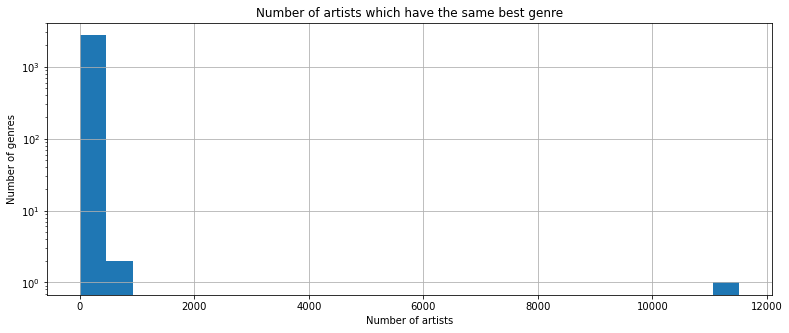

In [15]:
add_data.groupby('best_genre').size().hist(bins = 25, figsize = (13, 5))
plt.yscale('log')
plt.title('Number of artists which have the same best genre')
plt.xlabel('Number of artists')
_ = plt.ylabel('Number of genres')

In [16]:
add_data.groupby('best_genre').size()

best_genre
                    11522
a cappella             20
abstract                4
abstract beats          3
abstract hip hop       42
                    ...  
zim urban groove        1
zither                  1
zolo                   15
zouk                   13
zydeco                  1
Length: 2732, dtype: int64

In this case, we see that there are 11522 artists which do not have any genres attached to them, this probably comes from a lack of information about these artists in general from Spotify.

In [17]:
add_data = add_data[add_data['Genres'].map(len) > 0]

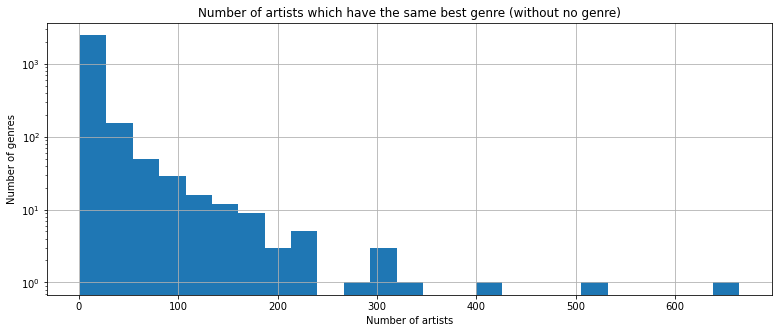

In [18]:
add_data.groupby('best_genre').size().hist(bins = 25, figsize = (13, 5))
plt.yscale('log')
plt.title('Number of artists which have the same best genre (without no genre)')
plt.xlabel('Number of artists')
_ = plt.ylabel('Number of genres')

In [22]:
add_data['Popularity'] = add_data['Info'].apply(lambda x: x['popularity'])

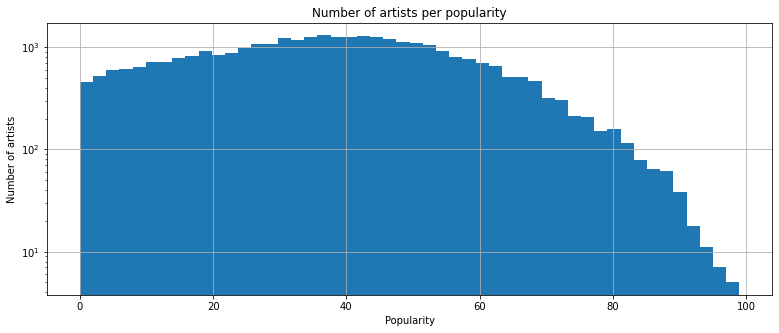

In [23]:
add_data['Popularity'].hist(bins = 50, figsize = (13, 5))
plt.yscale('log')
plt.title('Number of artists per popularity')
plt.xlabel('Popularity')
_ = plt.ylabel('Number of artists')

In [24]:
add_data.set_index('Artist')['Popularity'].sort_values()

Artist
sanso-xtro                 0
mika bomb                  0
monkey hole                0
murder at the registry     0
les têtes raides           0
                          ..
bun b                     98
dr                        98
drake                     98
taylor swift              99
swift                     99
Name: Popularity, Length: 33101, dtype: int64

In [25]:
add_data['Info'][34368]

{'external_urls': {'spotify': 'https://open.spotify.com/artist/6eUKZXaKkcviH0Ku9w2n3V'},
 'followers': {'href': None, 'total': 79118817},
 'genres': ['pop', 'uk pop'],
 'href': 'https://api.spotify.com/v1/artists/6eUKZXaKkcviH0Ku9w2n3V',
 'id': '6eUKZXaKkcviH0Ku9w2n3V',
 'images': [{'height': 640,
   'url': 'https://i.scdn.co/image/c9e693f336bc004af00c51bbf0a157e8b5af75f2',
   'width': 640},
  {'height': 320,
   'url': 'https://i.scdn.co/image/ebe13258cf525b7399ea1b34a25d38172b3023a1',
   'width': 320},
  {'height': 160,
   'url': 'https://i.scdn.co/image/05fc0a0a6b74757e87da8081c358f5ee972466db',
   'width': 160}],
 'name': 'Ed Sheeran',
 'popularity': 92,
 'type': 'artist',
 'uri': 'spotify:artist:6eUKZXaKkcviH0Ku9w2n3V'}

We can see that there are some issues with the Spotify API part where Artist such as She will be take as Ed Sheeran. This will be fixed by setting a bigger threshold on the number of users which are listening to the same artist.

In [26]:
top_data_percent = top_data.copy()
top_data_percent['Percent'] = top_data['Plays'] / top_data[['ID', 'Plays']].groupby('ID').Plays.transform('sum')
top_data_percent.head()

,ID,Artist_ID,Artist,Plays,Percent
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137,0.127842
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099,0.065745
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897,0.053661
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717,0.042893
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706,0.042235


In [27]:
all_data = top_data_percent.merge(add_data, on = 'Artist')
all_data.head()

,ID,Artist_ID,Artist,Plays,Percent,Info,Genres,best_genre,Popularity
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137,0.127842,{'external_urls': {'spotify': 'https://open.sp...,[riot grrrl],riot grrrl,19
1,0159d9ae1c8d76ab7fe3aa868a38e1da56cc06ab,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,42,0.011105,{'external_urls': {'spotify': 'https://open.sp...,[riot grrrl],riot grrrl,19
2,0285490bb23814cf0dc18a5668261e243572d4eb,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,41,0.010299,{'external_urls': {'spotify': 'https://open.sp...,[riot grrrl],riot grrrl,19
3,03d2e7186a6c29f281f6ff8b9bb2f7503822e7de,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,67,0.010819,{'external_urls': {'spotify': 'https://open.sp...,[riot grrrl],riot grrrl,19
4,04e0999468b2bbd922f0fdd41ffd9a5f26f97609,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,3,0.006122,{'external_urls': {'spotify': 'https://open.sp...,[riot grrrl],riot grrrl,19


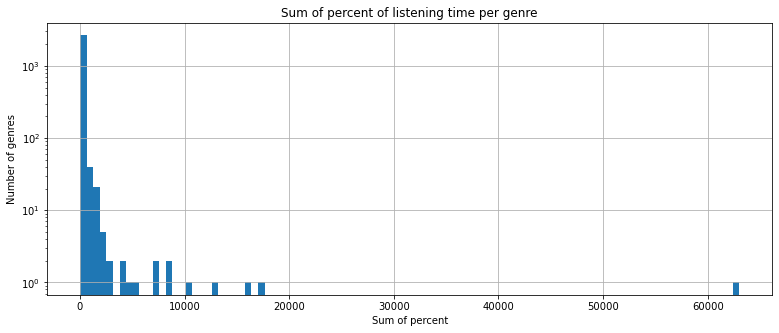

In [28]:
all_data[['best_genre', 'Percent']].groupby('best_genre').sum().hist(bins = 100, figsize = (13, 5))
plt.yscale('log')
plt.title('Sum of percent of listening time per genre')
plt.xlabel('Sum of percent')
_ = plt.ylabel('Number of genres')

In [29]:
all_data[['best_genre', 'Percent']].groupby('best_genre').sum().sort_values(by = 'Percent')

,Percent
best_genre,
kansas city hip hop,0.224099
belarusian pop,0.228380
ukrainian pop,0.242180
death doom,0.248212
backing track,0.254336
...,...
pop rock,10153.048772
electronica,13105.578309
alternative metal,16197.245614


In [30]:
all_data[all_data['best_genre'] == 'rock']

,ID,Artist_ID,Artist,Plays,Percent,Info,Genres,best_genre,Popularity
11549,00000c289a1829a808ac09c00daf10bc3c4e223b,8bfac288-ccc5-448d-9573-c33ea2aa5c30,red hot chili peppers,691,0.041338,{'external_urls': {'spotify': 'https://open.sp...,"[alternative rock, funk metal, funk rock, perm...",rock,86
11550,000429493d9716b66b02180d208d09b5b89fbe64,8bfac288-ccc5-448d-9573-c33ea2aa5c30,red hot chili peppers,234,0.016528,{'external_urls': {'spotify': 'https://open.sp...,"[alternative rock, funk metal, funk rock, perm...",rock,86
11551,0007e26aafcfc0b6dcb87d7041583fbb7cced88a,8bfac288-ccc5-448d-9573-c33ea2aa5c30,red hot chili peppers,159,0.024473,{'external_urls': {'spotify': 'https://open.sp...,"[alternative rock, funk metal, funk rock, perm...",rock,86
11552,000b0bb32f149504e1df3cce85b6bfd20cef3dd0,8bfac288-ccc5-448d-9573-c33ea2aa5c30,red hot chili peppers,46,0.004650,{'external_urls': {'spotify': 'https://open.sp...,"[alternative rock, funk metal, funk rock, perm...",rock,86
11553,000b2ee840cbda56e0f41c8f248c4fb7ee275db3,8bfac288-ccc5-448d-9573-c33ea2aa5c30,red hot chili peppers,87,0.009189,{'external_urls': {'spotify': 'https://open.sp...,"[alternative rock, funk metal, funk rock, perm...",rock,86
...,...,...,...,...,...,...,...,...,...
15547851,d20a1f4cf8c57854033155fe0f00df287607b65e,e6fe63ef-5fb8-4f83-a59d-fc13d85d5454,joe jackson band,141,0.011405,{'external_urls': {'spotify': 'https://open.sp...,"[album rock, art rock, classic rock, classic u...",rock,58
15547852,d77ad46a66cde6391040d20e00828b9fcc427f1a,e6fe63ef-5fb8-4f83-a59d-fc13d85d5454,joe jackson band,4,0.021978,{'external_urls': {'spotify': 'https://open.sp...,"[album rock, art rock, classic rock, classic u...",rock,58
15547853,d8773c223484c42c8c49a5faa3ad8cd32e2a86d6,e6fe63ef-5fb8-4f83-a59d-fc13d85d5454,joe jackson band,4,0.012346,{'external_urls': {'spotify': 'https://open.sp...,"[album rock, art rock, classic rock, classic u...",rock,58
15547854,d9dbb3881fa3829f2979298839e523ceae1d2f90,e6fe63ef-5fb8-4f83-a59d-fc13d85d5454,joe jackson band,268,0.011484,{'external_urls': {'spotify': 'https://open.sp...,"[album rock, art rock, classic rock, classic u...",rock,58


In [32]:
nbUser = top_data.groupby(by = 'Artist').size()
multipleUsers = nbUser[nbUser > 500].reset_index()[['Artist']]
multipleUsers

,Artist
0,!!!
1,#####
2,(hed) planet earth
3,*nsync
4,+44
...,...
5175,椎名林檎
5176,浜崎あゆみ
5177,菅野よう子
5178,近藤浩治


# For Robert

In [8]:
spotify_data = pd.read_csv('data/full_spotify_info.csv')
spotify_data

,Artist,Info
0,!!!,{'external_urls': {'spotify': 'https://open.sp...
1,!action pact!,{'external_urls': {'spotify': 'https://open.sp...
2,!deladap,{'external_urls': {'spotify': 'https://open.sp...
3,!distain,{'external_urls': {'spotify': 'https://open.sp...
4,!t.o.o.h.!,{'external_urls': {'spotify': 'https://open.sp...
...,...,...
44618,푸른새벽,{'external_urls': {'spotify': 'https://open.sp...
44619,한희정,[]
44620,휘성,[]
44621,１０,{'external_urls': {'spotify': 'https://open.sp...


In [9]:
merge_data = spotify_data.copy()
merge_data['Info'] = merge_data['Info'].map(lambda x: x if isinstance(x, str) else "{}").map(lambda x: ast.literal_eval(x))
merge_data.head()

,Artist,Info
0,!!!,{'external_urls': {'spotify': 'https://open.sp...
1,!action pact!,{'external_urls': {'spotify': 'https://open.sp...
2,!deladap,{'external_urls': {'spotify': 'https://open.sp...
3,!distain,{'external_urls': {'spotify': 'https://open.sp...
4,!t.o.o.h.!,{'external_urls': {'spotify': 'https://open.sp...


In [10]:
merge_data['Genres'] = merge_data['Info'].map(lambda x: x['genres'] if len(x) > 0 else [])
merge_data.head()

,Artist,Info,Genres
0,!!!,{'external_urls': {'spotify': 'https://open.sp...,"[alternative dance, dance rock, dance-punk, el..."
1,!action pact!,{'external_urls': {'spotify': 'https://open.sp...,"[anarcho-punk, uk82]"
2,!deladap,{'external_urls': {'spotify': 'https://open.sp...,"[balkan brass, electro swing]"
3,!distain,{'external_urls': {'spotify': 'https://open.sp...,"[dark electro, futurepop, neo-synthpop]"
4,!t.o.o.h.!,{'external_urls': {'spotify': 'https://open.sp...,[technical grindcore]


In [11]:
knn_genres = merge_data.merge(top_artists, on = 'Artist')
knn_genres = knn_genres.merge(top_data, on = 'Artist')[['ID', 'Genres']].groupby('ID')['Genres'].apply(list).apply(lambda x: set([item for sublist in x for item in sublist])).reset_index(name = 'Genres')
knn_genres

,ID,Genres
0,00000c289a1829a808ac09c00daf10bc3c4e223b,"{dance-punk, german power metal, folk rock, me..."
1,00001411dc427966b17297bf4d69e7e193135d89,"{austindie, bmore, glam rock, dance-punk, olym..."
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,"{british industrial, symphonic metal, dance po..."
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,"{swedish doom metal, progressive rock, melodic..."
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,"{abstract hip hop, dance-punk, minnesota hip h..."
...,...,...
357691,fffe8637bd8234309e871409c7ebef99a720afc1,"{dance-punk, swedish indie folk, soft rock, re..."
357692,fffe8c7f952d9b960a56ed4dcb40a415d924b224,"{noisecore, metal mineiro, christian rock, gla..."
357693,ffff9af9ae04d263dae91cb838b1f3a6725f5ffb,"{finnish edm, classic russian rock, eurodance,..."
357694,ffff9ef87a7d9494ada2f9ade4b9ff637c0759ac,"{glam rock, german power metal, melodic metalc..."


In [12]:
genres = merge_data['Genres'].tolist()
all_genres = [item for sublist in genres for item in sublist]
unique_genres = set(all_genres)
len(unique_genres)

4258

In [13]:
from collections import Counter
c = Counter(all_genres)
c.most_common(10)

[('rock', 665),
 ('dance pop', 511),
 ('hip hop', 475),
 ('country rock', 460),
 ('pop rock', 454),
 ('pop', 449),
 ('rap', 415),
 ('mellow gold', 412),
 ('adult standards', 402),
 ('classic rock', 395)]

In [14]:
def best_genre(l, c) :
    best = ""
    best_num = 0
    for elem in l:
        if(c[elem] > best_num) :
            best = elem
            best_num = c[elem]
    return best

In [15]:
merge_data['Best_genre'] = merge_data['Genres'].map(lambda x: best_genre(x, c))
merge_data.head()

,Artist,Info,Genres,Best_genre
0,!!!,{'external_urls': {'spotify': 'https://open.sp...,"[alternative dance, dance rock, dance-punk, el...",electronica
1,!action pact!,{'external_urls': {'spotify': 'https://open.sp...,"[anarcho-punk, uk82]",uk82
2,!deladap,{'external_urls': {'spotify': 'https://open.sp...,"[balkan brass, electro swing]",balkan brass
3,!distain,{'external_urls': {'spotify': 'https://open.sp...,"[dark electro, futurepop, neo-synthpop]",neo-synthpop
4,!t.o.o.h.!,{'external_urls': {'spotify': 'https://open.sp...,[technical grindcore],technical grindcore


In [16]:
unique_genres = pd.unique(merge_data['Best_genre'])
len(unique_genres)

2732

In [17]:
knn_best_genres = merge_data.merge(top_artists, on = 'Artist')
knn_best_genres = knn_best_genres.merge(top_data, on = 'Artist')[['ID', 'Best_genre']].groupby('ID')['Best_genre'].apply(list).reset_index(name = 'Genres')
knn_best_genres

,ID,Genres
0,00000c289a1829a808ac09c00daf10bc3c4e223b,"[rock, german rock, punk, hard rock, power met..."
1,00001411dc427966b17297bf4d69e7e193135d89,"[alternative rock, rock, rock, minimal techno,..."
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,"[gothic americana, , melancholia, art pop, dan..."
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,"[black metal, rock, alternative metal, alterna..."
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,"[hip hop, mellow gold, electronica, alternativ..."
...,...,...
357691,fffe8637bd8234309e871409c7ebef99a720afc1,"[pop rock, dream pop, alternative rock, indie ..."
357692,fffe8c7f952d9b960a56ed4dcb40a415d924b224,"[punk, alternative metal, alternative metal, m..."
357693,ffff9af9ae04d263dae91cb838b1f3a6725f5ffb,"[, russian rock, psychedelic trance, p funk, e..."
357694,ffff9ef87a7d9494ada2f9ade4b9ff637c0759ac,"[europop, rock, rock, alternative metal, metal..."


In [18]:
test = knn_best_genres.explode('Genres')
indices = test[test['Genres']==''].index
test = test.drop(indices)
group = test.groupby(['ID','Genres']).size()

In [19]:
new_test = group.to_frame(name = 'size').reset_index()
new_test.head(10)

,ID,Genres,size
0,00000c289a1829a808ac09c00daf10bc3c4e223b,alternative metal,2
1,00000c289a1829a808ac09c00daf10bc3c4e223b,alternative rock,1
2,00000c289a1829a808ac09c00daf10bc3c4e223b,dance pop,1
3,00000c289a1829a808ac09c00daf10bc3c4e223b,dance-punk,1
4,00000c289a1829a808ac09c00daf10bc3c4e223b,dark wave,1
5,00000c289a1829a808ac09c00daf10bc3c4e223b,german rock,2
6,00000c289a1829a808ac09c00daf10bc3c4e223b,hard rock,1
7,00000c289a1829a808ac09c00daf10bc3c4e223b,j-metal,1
8,00000c289a1829a808ac09c00daf10bc3c4e223b,melodic metalcore,2
9,00000c289a1829a808ac09c00daf10bc3c4e223b,neo classical metal,1


In [20]:
df_pivot = new_test.pivot(index = 'ID', columns= 'Genres', values = 'size').fillna(0)
df_pivot.head(1)

Genres,acid house,adult standards,album rock,alternative country,alternative hip hop,alternative metal,alternative r&b,alternative rock,ambient pop,anime score,...,turntablism,underground hip hop,urban contemporary,vapor soul,video game music,vocal jazz,vocal trance,waiata mo tamariki,world,world worship
ID,,,,,,,,,,,,,,,,,,,,,
00000c289a1829a808ac09c00daf10bc3c4e223b,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# takes much time to compute, I'd take smaller number of users
from sklearn.neighbors import NearestNeighbors
distances, indices =model_knn.kneighbors(df_pivot, n_neighbors= 6)
distances

array([[1.11022302e-16, 1.09645317e-01, 1.18762601e-01, 1.19591222e-01,
        1.20709871e-01, 1.20875553e-01],
       [1.11022302e-16, 5.93308417e-02, 6.20888659e-02, 6.33660460e-02,
        6.35411586e-02, 6.49887616e-02],
       [1.11022302e-16, 1.75424437e-02, 1.85185185e-02, 2.09363961e-02,
        2.13481109e-02, 2.42929644e-02],
       ...,
       [2.22044605e-16, 8.18594258e-02, 8.40365873e-02, 8.48147702e-02,
        8.92010140e-02, 9.12741277e-02],
       [0.00000000e+00, 6.89578133e-02, 7.16835062e-02, 7.41559404e-02,
        7.78611080e-02, 7.82358031e-02],
       [0.00000000e+00, 1.83112724e-02, 2.06572361e-02, 2.08975447e-02,
        2.11295717e-02, 2.11948669e-02]])

In [30]:
# show 6 the closest neighbours for all users
indices

array([[     0,  16770, 201559,  71997,  42676,  20478],
       [     1,  36801,  85857,  11951, 141057,  70016],
       [     2,  19444,  70731, 175385, 190756, 131465],
       ...,
       [216986, 103886,  41225,  45913,    912, 153387],
       [216987, 144055,  45916, 136785, 177840, 176859],
       [216988,  26637,  44238, 111185,  47734,  52101]])

In [ ]:
# We choose random user as an example
query_index = np.random.choice(df_pivot.shape[0])
print("Choosen user is: ",df_pivot.index[query_index])

In [ ]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10, n_jobs=-1)
model_knn.fit(df_pivot)
distances, indices =model_knn.kneighbors(df_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors= 6)

In [23]:
user = []
distance = []

for i in range(0, len(distances.flatten())):
    if i != 0:
        user.append(df_pivot.index[indices.flatten()[i]])
        distance.append(distances.flatten()[i])    

m=pd.Series(user,name='user')
d=pd.Series(distance,name='distance')
recommend = pd.concat([m,d], axis=1)
recommend = recommend.sort_values('distance',ascending=False)

print('Recommendations for {0}:\n'.format(df_pivot.index[query_index]))
for i in range(0,recommend.shape[0]):
    print('{0}: {1}, with distance of {2}'.format(i, recommend["user"].iloc[i], recommend["distance"].iloc[i]))

Recommendations for 582872ee401f2c226aca76399175f4619ee492fa:

0: 76c3ca575d4c7ca6ee74a74069aff2f8afd5abbf, with distance of 0.054473767235411974
1: 00f36859925cec57e855f8d2a81da758ae4a33a9, with distance of 0.05357910507203223
2: be6656cd0f815e5f0f09e888d345e546d2fb05e5, with distance of 0.052146321624643166
3: d909bea3dbeb459e2fc11c660826eb7e441d3589, with distance of 0.052056818348051315
4: aecdb0c1b4822ab45bbd4beaebcced836859b9f1, with distance of 0.038484335058387664


In [82]:
#alternative approach for finding similar genres, not sure if useful, but seems to work really nice
df_pivot = new_test.pivot(index = 'Genres', columns= 'ID', values = 'size').fillna(0)
df_pivot.head(1)

In [117]:
# We choose random genre
query_index = np.random.choice(df_pivot.shape[0])
print("Choosen genre is: ",df_pivot.index[query_index])

Choosen genre is:  turkish pop


In [118]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
model_knn.fit(df_pivot)
distances, indices =model_knn.kneighbors(df_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors= 6)

In [119]:
genre = []
distance = []

for i in range(0, len(distances.flatten())):
    if i != 0:
        genre.append(df_pivot.index[indices.flatten()[i]])
        distance.append(distances.flatten()[i])    

m=pd.Series(genre,name='genre')
d=pd.Series(distance,name='distance')
recommend = pd.concat([m,d], axis=1)
recommend = recommend.sort_values('distance',ascending=False)

print('Recommendations for {0}:\n'.format(df_pivot.index[query_index]))
for i in range(0,recommend.shape[0]):
    print('{0}: {1}, with distance of {2}'.format(i, recommend["genre"].iloc[i], recommend["distance"].iloc[i]))

Recommendations for turkish pop:

0: dance pop, with distance of 0.9424082257835734
1: pop, with distance of 0.9387518651842167
2: balkan brass, with distance of 0.933226701731537
3: indie r&b, with distance of 0.9036830599365128
4: turkish rock, with distance of 0.3581747964193722
